In [1]:
import os, sys
#sys.path.append('/Users/hhsieh/anaconda3/envs/astroconda/lib/python3.6/site-packages')
#sys.path.append('/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages')
#print(sys.version)
import datetime,ssl
import math
import numpy as np
import subprocess
from os import path
import astropy.units as u
import astropy.coordinates as coord
from astropy.time import Time, TimeDelta
from astropy.table import Table
from astropy.coordinates import SkyCoord,Angle
from astropy.units import Quantity
from astroquery.gaia import Gaia
from astroquery.jplhorizons import Horizons
import matplotlib.pyplot as plt
import matplotlib.figure as fig
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from matplotlib.ticker import NullFormatter, MaxNLocator, ScalarFormatter, MultipleLocator, FormatStrFormatter
from urllib.parse import urlencode
from urllib.request import urlretrieve
import IPython.display
from PIL import Image


In [2]:
def output_write_log_entry(log_filepath,log_entry):
    print('{:s} - {:s}'.format(datetime.datetime.today().strftime('%Y-%m-%d %H:%M:%S'),log_entry))
    with open(log_filepath,'a') as of:
        of.write('{:s} - {:s}\n'.format(datetime.datetime.today().strftime('%Y-%m-%d %H:%M:%S'),log_entry))
    return None

def get_horizons_obj_desig(object_name):
    horizons_obj_desig = object_name
    if object_name == '66P':  horizons_obj_desig = '90000688;'
    if object_name == '16P':  horizons_obj_desig = '90000273'
    if object_name == '43P':  horizons_obj_desig = '90000507'
    if object_name == '104P': horizons_obj_desig = '90000954'
    if object_name == '213P': horizons_obj_desig = '90001150'
    if object_name == 'C/2019 Q4': horizons_obj_desig = '90004424'
    return(horizons_obj_desig)

def remove_extra_characters(obj_name):
    name_length = len(obj_name)
    obj_name_ed = ''
    for idx in range(0,name_length):
        if obj_name[idx] != ' ' and obj_name[idx] != '/' and obj_name[idx] != '-':
            obj_name_ed = '{:s}{:s}'.format(obj_name_ed,obj_name[idx])
    return obj_name_ed

def observatory_code_lookup(o_observatory_id):
    # Specify user-readable observatory codes
    if   o_observatory_id == '568': o_observatory_code = 'MKO'  # Mauna Kea
    elif o_observatory_id == '807': o_observatory_code = 'CTIO' # Cerro Tololo
    elif o_observatory_id == '809': o_observatory_code = 'LSO'  # La Silla
    elif o_observatory_id == '309': o_observatory_code = 'VLT'  # VLT, Paranal
    elif o_observatory_id == 'VLT': o_observatory_code = 'VLT'  # Paranal
    elif o_observatory_id == 'I33': o_observatory_code = 'SOAR' # SOAR, Cerro Pachon
    elif o_observatory_id == 'I11': o_observatory_code = 'GemS' # Gemini-South, Cerro Pachon
    elif o_observatory_id == '304': o_observatory_code = 'LCO'  # Las Campanas
    elif o_observatory_id == 'G37': o_observatory_code = 'DCT'  # Discovery Channel Telescope
    elif o_observatory_id == 'F51': o_observatory_code = 'PS1'  # Pan-STARRS1
    else: o_observatory_code = o_observatory_id

    return o_observatory_code


In [3]:
def query_horizons(object_id,obs_code,obs_datetime,time_step,log_filepath):
    # Create and execute JPL Horizons query for a given object, observatory code, date, and time step
    output_write_log_entry(log_filepath,'Executing Horizons query...')
    date_start = Time('{:s}'.format(obs_datetime),scale='utc',format='iso')
    dt = TimeDelta(1,format='jd')
    date_end = date_start+dt
    obj = Horizons(id=object_id, location=obs_code,epochs={'start':date_start.iso,'stop':date_end.iso,'step':time_step})
    query_successful = True
    max_retries = 50
    ephems = ''
        
    # try comet mode
    output_write_log_entry(log_filepath,'Trying Horizons in comet mode...')
    for _ in range(max_retries):
        try:
            if (not os.environ.get('PYTHONHTTPSVERIFY','') and getattr(ssl,'_create_unverified_context',None)):
                ssl._create_default_https_context = ssl._create_unverified_context
            ephems = obj.ephemerides(closest_apparition=True,no_fragments=True)
            print(obj.uri) # print Horizons query URL
        except Exception:
            print('.',end='')
        else:
            print('')
            #print(ephems)
            break
    else:
        output_write_log_entry(log_filepath,'Horizons query (comet mode) failed. Maximum retries reached.')
        query_successful = False
        
    # try asteroid mode
    if not query_successful:
        output_write_log_entry(log_filepath,'Trying Horizons in asteroid mode...')
        for _ in range(max_retries):
            try:
                if (not os.environ.get('PYTHONHTTPSVERIFY','') and getattr(ssl,'_create_unverified_context',None)):
                    ssl._create_default_https_context = ssl._create_unverified_context
                ephems = obj.ephemerides()
            except Exception:
                print('.',end='')
            else:
                print('')
                #print(ephems)
                break
        else:
            output_write_log_entry(log_filepath,'Horizons query (asteroid mode) failed. Maximum retries reached.')
            output_write_log_entry(log_filepath,obj.uri)
            query_successful = False
            
    return ephems


In [4]:
def retrieve_nightly_ephems(object_id,obs_code,obs_datetime,time_step_min,log_filepath):
    # Sends a query to JPL Horizons for a given object, observatory code, date, and time step,
    #   and outputs date/time, RA, and Dec to an astropy Table
    output_write_log_entry(log_filepath,'Retrieving nightly ephemeris table...')
    time_step = '{:d}m'.format(time_step_min)
    ephems = query_horizons(object_id,obs_code,obs_datetime,time_step,log_filepath)
    num_lines_all = len(ephems)
    num_lines     = 0
    
    # Count ephemeris entries that meet night-time (or astronomical twilight) and airmass requirements
    for idx in range(0,num_lines_all):
        if (ephems[idx]['solar_presence'] == '' or ephems[idx]['solar_presence'] == 'A') and ephems[idx]['airmass'] < 2.7:
            num_lines += 1
    
    # Initialize ephemeris arrays
    eph_datetime_str = [0 for idx in range(num_lines)]
    eph_ra           = [0 for idx in range(num_lines)]
    eph_dec          = [0 for idx in range(num_lines)]

    # Save ephemeris entries that meet night-time (or astronomical twilight) and airmass requirements
    idx2 = 0
    for idx1 in range(0,num_lines_all):
        #print(ephems[idx1]['solar_presence'],ephems[idx1]['airmass'])
        if (ephems[idx1]['solar_presence'] == '' or ephems[idx1]['solar_presence'] == 'A') and ephems[idx1]['airmass'] < 2.7:
            eph_datetime_str[idx2] = ephems[idx1]['datetime_str']
            eph_ra[idx2]           = ephems[idx1]['RA']
            eph_dec[idx2]          = ephems[idx1]['DEC']
            idx2 += 1

    # Create ephemeris table for entries that meet night-time (or astronomical twilight) and airmass requirements
    #print(eph_datetime_str,eph_ra,eph_dec)
    ephem_table,distance_traveled_arcsec,start_time,end_time = '',0,0,0
    if eph_datetime_str != []:
        ephem_table = Table()
        ephem_table = Table([eph_datetime_str,eph_ra,eph_dec],names=('datetime','ra','dec'),dtype=('S17','f8','f8'))
    
        ephem_table['clear'] = True
        ephem_table['nearby_star_idx'] = -1
        ephem_table['nearby_star_mag'] = 30.0
        ephem_table['nearby_star_dist'] = 9999.0

        c1 = SkyCoord((ephem_table[0]['ra']/180*math.pi)*u.radian,(ephem_table[0]['dec']/180*math.pi)*u.radian,frame='icrs')
        c2 = SkyCoord((ephem_table[len(ephem_table)-1]['ra']/180*math.pi)*u.radian,(ephem_table[len(ephem_table)-1]['dec']/180*math.pi)*u.radian,frame='icrs')
        sep = c1.separation(c2)
        distance_traveled_arcsec = sep.arcsecond

        # Confirm start and end times and positions of object when it is observable
        output_write_log_entry(log_filepath,'Start time and position: {:s} {:f} {:f}'.format(ephem_table[0]['datetime'],ephem_table[0]['ra'],ephem_table[0]['dec']))
        output_write_log_entry(log_filepath,'End time and position:   {:s} {:f} {:f}'.format(ephem_table[len(ephem_table)-1]['datetime'],ephem_table[len(ephem_table)-1]['ra'],ephem_table[len(ephem_table)-1]['dec']))
        output_write_log_entry(log_filepath,'Distance traveled:       {:.1f} arcsec'.format(distance_traveled_arcsec))
        
        start_time = ephem_table[0]['datetime']
        end_time   = ephem_table[len(ephem_table)-1]['datetime']
    
    return ephem_table,distance_traveled_arcsec,start_time,end_time


In [5]:
def retrieve_star_field_gaia(output_path,ephem_table,fov_arcmin,log_filepath):
    output_write_log_entry(log_filepath,'Retrieving Gaia sources...')
    # Compute/retrieve parameters needed for field star retrieval
    num_lines  = len(ephem_table)                  # number of ephemeris entries
    center_idx = int(num_lines/2)                  # approximate midpoint of observing window
    start_ra   = ephem_table[0]['ra']              # RA at start of observing window
    start_dec  = ephem_table[0]['dec']             # Dec at start of observing window
    mid_ra     = ephem_table[center_idx]['ra']     # RA at approximate midpoint of observing window
    mid_dec    = ephem_table[center_idx]['dec']    # Dec at approximate midpoint of observing window
    end_ra     = ephem_table[num_lines-1]['ra']    # RA at end of observing window
    end_dec    = ephem_table[num_lines-1]['dec']   # Dec at end of observing window
    field_radius_deg = (fov_arcmin / 60 / 2) * (2**0.5)

    query_successful = True
    max_retries = 50
    for _ in range(max_retries):
        try:
            if (not os.environ.get('PYTHONHTTPSVERIFY','') and getattr(ssl,'_create_unverified_context',None)):
                ssl._create_default_https_context = ssl._create_unverified_context
            adql_query = "SELECT * FROM gaiadr1.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),CIRCLE('ICRS',{:f},{:f},{:f}))=1;".format(mid_ra,mid_dec,field_radius_deg)
            job = Gaia.launch_job_async(adql_query,dump_to_file=False)
            gaia_results_table = job.get_results()
        except Exception:
            print('.',end='')
        else:
            print('')
            break
    else:
        output_write_log_entry(log_filepath,'Gaia source search failed. Maximum retries reached.')
        query_successful = False

        
    if query_successful:
        output_write_log_entry(log_filepath,'{:d} Gaia sources found.'.format(len(gaia_results_table)))
    
    return gaia_results_table,query_successful

def retrieve_star_field_gaia_radec(output_path,ra_coord,dec_coord,fov_arcmin,log_filepath):
    output_write_log_entry(log_filepath,'Retrieving Gaia sources...')
    # Compute/retrieve parameters needed for field star retrieval
    mid_ra     = ra_coord
    mid_dec    = dec_coord
    field_radius_deg = (fov_arcmin / 60 / 2) * (2**0.5)

    query_successful = True
    max_retries = 50
    for _ in range(max_retries):
        try:
            if (not os.environ.get('PYTHONHTTPSVERIFY','') and getattr(ssl,'_create_unverified_context',None)):
                ssl._create_default_https_context = ssl._create_unverified_context
            adql_query = "SELECT * FROM gaiadr1.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),CIRCLE('ICRS',{:f},{:f},{:f}))=1;".format(mid_ra,mid_dec,field_radius_deg)
            job = Gaia.launch_job_async(adql_query,dump_to_file=False)
            gaia_results_table = job.get_results()
        except Exception:
            print('.',end='')
        else:
            print('')
            break
    else:
        output_write_log_entry(log_filepath,'Gaia source search failed. Maximum retries reached.')
        query_successful = False

        
    if query_successful:
        output_write_log_entry(log_filepath,'{:d} Gaia sources found.'.format(len(gaia_results_table)))
    
    return gaia_results_table,query_successful


In [ ]:
def retrieve_refcat_sources(ra_deg,dec_deg,radius_arcmin,source_list_filepath):
    # Retrieve refcat sources
    refcat_table = 0
    print('Retrieving refcat sources within {:.1f} arcmin of RA={:.6f},Dec={:.6f}'.format(radius_arcmin,ra_deg,dec_deg))
    with open(source_list_filepath,'w') as outf:
        outf.write(' objRA       objDec      gmag   gerr  rmag   rerr  imag   ierr  zmag   zerr\n')
    with open(source_list_filepath,'a') as outf:
        outf.write(' objRA       objDec      gmag   gerr  rmag   rerr  imag   ierr  zmag   zerr\n')
        radius_deg = radius_arcmin / 60
        cmd_ra  = '{:f}'.format(ra_deg)
        cmd_dec = '{:f}'.format(dec_deg)
        cmd_radius = '{:f}'.format(radius_deg)
        cmd_refcat,cmd_dir = '/users/hhsieh/astro/tools/refcat','-dir'
        if os.path.exists('/volumes/Fantom12a/refcat_catalog/'):
            directories = '/volumes/Fantom12a/refcat_catalog/00_m_16_binary,/volumes/Fantom12a/refcat_catalog/16_m_17_binary,/volumes/Fantom12a/refcat_catalog/17_m_18_binary,/volumes/Fantom12a/refcat_catalog/18_m_19_binary,/volumes/Fantom12a/refcat_catalog/19_m_20_binary'
        elif os.path.exists('/volumes/RavPower_1TB_A/refcat_catalog/'):
            directories = '/volumes/RavPower_1TB_A/refcat_catalog/00_m_16_binary,/volumes/RavPower_1TB_A/refcat_catalog/16_m_17_binary,/volumes/RavPower_1TB_A/refcat_catalog/17_m_18_binary,/volumes/RavPower_1TB_A/refcat_catalog/18_m_19_binary,/volumes/RavPower_1TB_A/refcat_catalog/19_m_20_binary'
            
        var_fields = 'RA,Dec,g,dg,r,dr,i,di,z,dz'
        cmd_rad,cmd_var,cmd_nohdr = '-rad','-var','-nohdr'
        cmd = [cmd_refcat,cmd_ra,cmd_dec,cmd_dir,directories,cmd_rad,cmd_radius,cmd_var,var_fields,cmd_nohdr]
        print(cmd)
        subprocess.call(cmd,stdout=outf)
    print('Refcat catalog sources written to {:s}.'.format(source_list_filepath))
            
    # parse local file into astropy.table object
    objRA  = np.genfromtxt(source_list_filepath,skip_header=1,usecols=(0))
    objDec = np.genfromtxt(source_list_filepath,skip_header=1,usecols=(1))
    gmag   = np.genfromtxt(source_list_filepath,skip_header=1,usecols=(2))
    gerr   = np.genfromtxt(source_list_filepath,skip_header=1,usecols=(3))
    rmag   = np.genfromtxt(source_list_filepath,skip_header=1,usecols=(4))
    rerr   = np.genfromtxt(source_list_filepath,skip_header=1,usecols=(5))
    imag   = np.genfromtxt(source_list_filepath,skip_header=1,usecols=(6))
    ierr   = np.genfromtxt(source_list_filepath,skip_header=1,usecols=(7))
    zmag   = np.genfromtxt(source_list_filepath,skip_header=1,usecols=(8))
    zerr   = np.genfromtxt(source_list_filepath,skip_header=1,usecols=(9))
    refcat_table = Table([objRA,objDec,gmag,gerr,rmag,rerr,imag,ierr,zmag,zerr], \
        names=('right_ascension','declination','gp1_mag','gp1_err','rp1_mag','rp1_err','ip1_mag','ip1_err','zp1_mag','zp1_err'), \
        dtype=('f8','f8','f8','f8','f8','f8','f8','f8','f8','f8'))
    num_refcat_sources = len(refcat_table)
    if num_refcat_sources > 0:
        idx = 0
        # Remove sources that are likely to be saturated or have dummy values (i.e., -999)
        while idx < len(refcat_table):
            if refcat_table[idx]['gp1_mag'] < 10 or refcat_table[idx]['rp1_mag'] < 10 or refcat_table[idx]['ip1_mag'] < 10 or refcat_table[idx]['zp1_mag'] < 10:
                refcat_table.remove_row(idx)
            else:
                idx += 1
        num_refcat_sources = len(refcat_table)
    if num_refcat_sources > 0:
        print('{:d} refcat catalog sources retrieved.'.format(num_refcat_sources))
    else:
        print('No refcat calibration sources found.')
                
    return refcat_table


def match_refcat_sources(field_source_table,refcat_table,match_threshold_arcsec):
    # Find matches for sources extracted by tphot in PS1 source catalog
    calib_star_table = 0
    match_threshold = match_threshold_arcsec / 3600
    print('Finding matches for sources extracted by tphot in refcat catalog...')
    calib_star_table = Table(names=('star_id', \
        'RA','Dec','refcat_RA','refcat_Dec','star_sep','gp1_mag','gp1_err','rp1_mag','rp1_err','ip1_mag', \
        'ip1_err','zp1_mag','zp1_err','g_sdss_mag','g_sdss_err','r_sdss_mag','r_sdss_err','i_sdss_mag', \
        'i_sdss_err','z_sdss_mag','z_sdss_err','B_mag','B_err','V_mag','V_err','Rc_mag','Rc_err','Ic_mag', \
        'Ic_err'))
    num_field_sources,num_refcat_stars = len(field_source_table),len(refcat_table)
    stars_matched = 0
    for idx1 in range(0,num_field_sources):
        idx2,star_matched = 0,0
        while idx2 < num_refcat_stars and star_matched == 0:
            distance = ((field_source_table[idx1]['RA'] - refcat_table[idx2]['right_ascension'])**2 +
                (field_source_table[idx1]['Dec'] - refcat_table[idx2]['declination'])**2)**0.5
            if distance < match_threshold:  # If target matches within match_threshold in deg
                star_matched = 1
                copy_fieldsource_row_to_calibstar_table(field_source_table,calib_star_table,idx1)
                calib_star_table[stars_matched]['refcat_RA']  = float(refcat_table[idx2]['right_ascension'])
                calib_star_table[stars_matched]['refcat_Dec'] = float(refcat_table[idx2]['declination'])
                calib_star_table[stars_matched]['star_sep'] = distance * 3600
                calib_star_table[stars_matched]['gp1_mag'] = refcat_table[idx2]['gp1_mag']
                calib_star_table[stars_matched]['gp1_err'] = refcat_table[idx2]['gp1_err']
                calib_star_table[stars_matched]['rp1_mag'] = refcat_table[idx2]['rp1_mag']
                calib_star_table[stars_matched]['rp1_err'] = refcat_table[idx2]['rp1_err']
                calib_star_table[stars_matched]['ip1_mag'] = refcat_table[idx2]['ip1_mag']
                calib_star_table[stars_matched]['ip1_err'] = refcat_table[idx2]['ip1_err']
                calib_star_table[stars_matched]['zp1_mag'] = refcat_table[idx2]['zp1_mag']
                calib_star_table[stars_matched]['zp1_err'] = refcat_table[idx2]['zp1_err']
                stars_matched += 1
            else:
                idx2 += 1
    print('{:d} extracted sources matched to refcat catalog sources.'.format(stars_matched))
    if stars_matched == 0:
        print('No refcat sources matched to image sources using match_refcat_sources().')

    return calib_star_table


In [6]:
def generate_finder_chart_gaia(output_path,object_id,obs_code,obs_datetime,fov_arcmin,start_time,end_time,ephem_table,gaia_results_table,log_filepath):
    # Generates finder chart showing star field (from source catalog), object path
    #   during the nightly observing window, and close encounters with background stars
    output_write_log_entry(log_filepath,'Generating Gaia finder chart for {:s} for {:s}, {:s}...'.format(object_id,obs_code,obs_datetime))
    
    majorFormatter0 = FormatStrFormatter('%d')
    majorFormatter1 = FormatStrFormatter('%.1f')
    majorFormatter2 = FormatStrFormatter('%.2f')
    majorFormatter3 = FormatStrFormatter('%.3f')
    majorFormatter4 = FormatStrFormatter('%.4f')
    
    finder_chart_name = 'finder_chart_' + remove_extra_characters(object_id) + '_' + obs_code + '_'+ obs_datetime[0:4] + obs_datetime[5:7] + obs_datetime[8:10]

    ra_toplot  = coord.Angle((ephem_table['ra']/180*math.pi)*u.rad)
    dec_toplot = coord.Angle((ephem_table['dec']/180*math.pi)*u.rad)

    stars_ra_toplot  = coord.Angle((gaia_results_table['ra']/180*math.pi)*u.rad)
    stars_dec_toplot = coord.Angle((gaia_results_table['dec']/180*math.pi)*u.rad)

    # initialize and populate star size array
    star_size = [0 for idx in range(len(gaia_results_table))]
    for idx in range(0,len(gaia_results_table)):
        star_size[idx] = 55 * (10**(0.15*(21 - gaia_results_table[idx]['phot_g_mean_mag'])))
    
    num_lines  = len(ephem_table)
    center_idx = int(num_lines/2)
    mid_ra     = ephem_table[center_idx]['ra']
    mid_dec    = ephem_table[center_idx]['dec']

    a_mid_ra   = Angle(mid_ra,u.deg)
    a_mid_dec  = Angle(mid_dec,u.deg)

    x_min  = mid_ra-(0.8*fov_arcmin/2/60/np.cos(a_mid_dec.rad))
    x_max  = mid_ra+(0.8*fov_arcmin/2/60/np.cos(a_mid_dec.rad))
    y_min  = mid_dec-(0.8*fov_arcmin/2/60)
    y_max  = mid_dec+(0.8*fov_arcmin/2/60)
    xlim   = [x_min,x_max]
    ylim   = [y_min,y_max]

    major_xticks = np.arange(int(xlim[0]-1),int(xlim[1]+1),0.05)
    minor_xticks = np.arange(int(xlim[0]-1),int(xlim[1]+1),0.01)
    major_yticks = np.arange(int(ylim[0]-1),int(ylim[1]+1),0.01)
    minor_yticks = np.arange(int(ylim[0]-1),int(ylim[1]+1),0.002)
    
    fig = plt.figure(figsize=(15,15))
    rect_plot = [0.10,0.10,0.60,0.60]
    axPlot  = plt.axes(rect_plot)
    axPlot.plot(ra_toplot.deg,dec_toplot.deg,ls='--',zorder=4)
    axPlot.scatter(stars_ra_toplot.deg,stars_dec_toplot.deg,marker='.',color='#000000',s=star_size,rasterized=True,zorder=2)
    window_start = axPlot.scatter(ra_toplot[0].deg,dec_toplot[0].deg,marker='+',s=150,lw=3,color='#00a822',zorder=7)
    window_end   = axPlot.scatter(ra_toplot[len(ra_toplot)-1].deg,dec_toplot[len(dec_toplot)-1].deg,marker='x',s=80,lw=3,color='#cc0e00',zorder=7)
    axPlot.xaxis.set_major_formatter(majorFormatter2)
    axPlot.yaxis.set_major_formatter(majorFormatter2)
    axPlot.tick_params(axis='both',which='both',direction='in',labelsize=10)
    axPlot.set_xlabel('Right ascension (deg)',fontsize=14,labelpad=10)
    axPlot.set_ylabel('Declination (deg)',fontsize=14,labelpad=10)
    axPlot.set_xlim(xlim)
    axPlot.set_ylim(ylim)
    axPlot.set_xticks(major_xticks)
    axPlot.set_xticks(minor_xticks,minor=True)
    axPlot.set_yticks(major_yticks)
    axPlot.set_yticks(minor_yticks,minor=True)
    axPlot.set_xlim(xlim)
    axPlot.set_ylim(ylim)
    axPlot.invert_xaxis()

    for idx in range(len(stars_ra_toplot)):
        if (stars_ra_toplot.deg[idx] > x_min) and (stars_ra_toplot.deg[idx] < x_max) and (stars_dec_toplot.deg[idx] > y_min) and (stars_dec_toplot.deg[idx] < y_max):
            axPlot.text(stars_ra_toplot.deg[idx]-0.002,stars_dec_toplot.deg[idx]-0.0007,'{:d}'.format(idx+1),fontsize=10,color='#0000ff',zorder=3)

    print(start_time,end_time)
    
    props1 = dict(facecolor='white',alpha=1.0,boxstyle='round,pad=0.50',edgecolor='black')
    props2 = dict(facecolor='white',alpha=1.0,boxstyle='round,pad=0.50',edgecolor='white')
    axPlot.text(0.03,0.035,'{:s} ({:s}, UT {:s} - {:s})\nField center: {:s} {:s}\nField size: {:.2f} arcmin x {:.2f} arcmin'.format(object_id,observatory_code_lookup(obs_code),start_time,end_time[-5:],a_mid_ra.to_string(unit=u.hour,sep=':'),a_mid_dec.to_string(unit=u.degree,sep=':'),fov_arcmin,fov_arcmin),fontsize=12,transform=axPlot.transAxes,bbox=props1)

    axPlot.grid(True,zorder=1)

    axPlot.legend([window_start,window_end],['Observing window start','Observing window end'],ncol=1,scatterpoints=1,handletextpad=0.2,columnspacing=0.,fontsize=13,edgecolor='#000000',framealpha=1,labelspacing=0.4,loc='upper right',bbox_to_anchor=(0.99,0.99))

    plt.draw()
    plot_filename = finder_chart_name
    plot_filepath = output_path + plot_filename + '_gaia.pdf'
    plt.savefig(plot_filepath,format='pdf',transparent=True,dpi=400,bbox_inches='tight')
    plt.clf()
    plt.cla()
    plt.close()
    output_write_log_entry(log_filepath,'>>> Finder chart written to {:s}.'.format(plot_filepath))

    return plot_filepath

def generate_finder_chart_gaia_radec(output_path,ra_coord,dec_coord,fov_arcmin,gaia_results_table,log_filepath):
    # Generates finder chart showing star field (from source catalog), object path
    #   during the nightly observing window, and close encounters with background stars
    output_write_log_entry(log_filepath,'Generating Gaia finder chart for ra={:.6f}, dec={:.6f}...'.format(ra_coord,dec_coord))
    
    majorFormatter0 = FormatStrFormatter('%d')
    majorFormatter1 = FormatStrFormatter('%.1f')
    majorFormatter2 = FormatStrFormatter('%.2f')
    majorFormatter3 = FormatStrFormatter('%.3f')
    majorFormatter4 = FormatStrFormatter('%.4f')
    
    finder_chart_name = 'finder_chart_ra{:.6f}_dec{:.6f}'.format(ra_coord,dec_coord)

    ra_toplot  = coord.Angle((ra_coord/180*math.pi)*u.rad)
    dec_toplot = coord.Angle((dec_coord/180*math.pi)*u.rad)

    stars_ra_toplot  = coord.Angle((gaia_results_table['ra']/180*math.pi)*u.rad)
    stars_dec_toplot = coord.Angle((gaia_results_table['dec']/180*math.pi)*u.rad)

    # initialize and populate star size array
    star_size = [0 for idx in range(len(gaia_results_table))]
    for idx in range(0,len(gaia_results_table)):
        star_size[idx] = 55 * (10**(0.15*(21 - gaia_results_table[idx]['phot_g_mean_mag'])))
    
    a_mid_ra   = Angle(ra_coord,u.deg)
    a_mid_dec  = Angle(dec_coord,u.deg)

    x_min  = mid_ra-(0.8*fov_arcmin/2/60/np.cos(a_mid_dec.rad))
    x_max  = mid_ra+(0.8*fov_arcmin/2/60/np.cos(a_mid_dec.rad))
    y_min  = mid_dec-(0.8*fov_arcmin/2/60)
    y_max  = mid_dec+(0.8*fov_arcmin/2/60)
    xlim   = [x_min,x_max]
    ylim   = [y_min,y_max]

    major_xticks = np.arange(int(xlim[0]-1),int(xlim[1]+1),0.05)
    minor_xticks = np.arange(int(xlim[0]-1),int(xlim[1]+1),0.01)
    major_yticks = np.arange(int(ylim[0]-1),int(ylim[1]+1),0.01)
    minor_yticks = np.arange(int(ylim[0]-1),int(ylim[1]+1),0.002)
    
    fig = plt.figure(figsize=(15,15))
    rect_plot = [0.10,0.10,0.60,0.60]
    axPlot  = plt.axes(rect_plot)
    axPlot.plot(ra_toplot.deg,dec_toplot.deg,ls='--',zorder=4)
    axPlot.scatter(stars_ra_toplot.deg,stars_dec_toplot.deg,marker='.',color='#000000',s=star_size,rasterized=True,zorder=2)
    window_start = axPlot.scatter(ra_toplot.deg,dec_toplot.deg,marker='+',s=150,lw=3,color='#00a822',zorder=7)
    axPlot.xaxis.set_major_formatter(majorFormatter2)
    axPlot.yaxis.set_major_formatter(majorFormatter2)
    axPlot.tick_params(axis='both',which='both',direction='in',labelsize=10)
    axPlot.set_xlabel('Right ascension (deg)',fontsize=14,labelpad=10)
    axPlot.set_ylabel('Declination (deg)',fontsize=14,labelpad=10)
    axPlot.set_xlim(xlim)
    axPlot.set_ylim(ylim)
    axPlot.set_xticks(major_xticks)
    axPlot.set_xticks(minor_xticks,minor=True)
    axPlot.set_yticks(major_yticks)
    axPlot.set_yticks(minor_yticks,minor=True)
    axPlot.set_xlim(xlim)
    axPlot.set_ylim(ylim)
    axPlot.invert_xaxis()

    for idx in range(len(stars_ra_toplot)):
        if (stars_ra_toplot.deg[idx] > x_min) and (stars_ra_toplot.deg[idx] < x_max) and (stars_dec_toplot.deg[idx] > y_min) and (stars_dec_toplot.deg[idx] < y_max):
            axPlot.text(stars_ra_toplot.deg[idx]-0.002,stars_dec_toplot.deg[idx]-0.0007,'{:d}'.format(idx+1),fontsize=10,color='#0000ff',zorder=3)
    
    props1 = dict(facecolor='white',alpha=1.0,boxstyle='round,pad=0.50',edgecolor='black')
    props2 = dict(facecolor='white',alpha=1.0,boxstyle='round,pad=0.50',edgecolor='white')
    axPlot.text(0.03,0.035,'{:s} (Field center: {:s} {:s}\nField size: {:.2f} arcmin x {:.2f} arcmin'.format(a_mid_ra.to_string(unit=u.hour,sep=':'),a_mid_dec.to_string(unit=u.degree,sep=':'),fov_arcmin,fov_arcmin),fontsize=12,transform=axPlot.transAxes,bbox=props1)

    axPlot.grid(True,zorder=1)

    #axPlot.legend([window_start,window_end],['Observing window start','Observing window end'],ncol=1,scatterpoints=1,handletextpad=0.2,columnspacing=0.,fontsize=13,edgecolor='#000000',framealpha=1,labelspacing=0.4,loc='upper right',bbox_to_anchor=(0.99,0.99))

    plt.draw()
    plot_filename = finder_chart_name
    plot_filepath = output_path + plot_filename + '_gaia.pdf'
    plt.savefig(plot_filepath,format='pdf',transparent=True,dpi=400,bbox_inches='tight')
    plt.clf()
    plt.cla()
    plt.close()
    output_write_log_entry(log_filepath,'>>> Finder chart written to {:s}.'.format(plot_filepath))

    return plot_filepath


In [7]:
def convert_radec_to_xypix_dss(ra_deg,dec_deg,ra_max_deg,dec_max_deg,ra_total_deg,dec_total_deg,fov_arcmin):
    xpix = (ra_max_deg - ra_deg)/ra_total_deg * (fov_arcmin*60)
    ypix = (dec_max_deg - dec_deg)/dec_total_deg * (fov_arcmin*60)
    return xpix,ypix


In [8]:
def generate_finder_chart_dss(output_path,object_id,obs_code,obs_datetime,fov_arcmin,start_time,end_time,ephem_table,log_filepath):
    # Generates finder chart showing star field (from DSS image) and object path during the nightly observing window
    output_write_log_entry(log_filepath,'Generating DSS finder chart for {:s} for {:s}, {:s}...'.format(object_id,obs_code,obs_datetime))
    
    finder_chart_name = 'finder_chart_' + remove_extra_characters(object_id) + '_' + obs_code + '_'+ obs_datetime[0:4] + obs_datetime[5:7] + obs_datetime[8:10]
    sky_field_image_filename_png_final = 'finder_chart_' + remove_extra_characters(object_id) + '_' + obs_code + '_'+ obs_datetime[0:4] + obs_datetime[5:7] + obs_datetime[8:10] + '_dss.png'
    
    obs_datetime_start = Time(obs_datetime,scale='utc',format='iso')
    fov_arcmin = 0.8 * fov_arcmin

    ra_toplot  = coord.Angle((ephem_table['ra']/180*math.pi)*u.rad)
    dec_toplot = coord.Angle((ephem_table['dec']/180*math.pi)*u.rad)

    num_lines  = len(ephem_table)
    center_idx = int(num_lines/2)
    mid_ra     = ephem_table[center_idx]['ra']
    mid_dec    = ephem_table[center_idx]['dec']

    a_mid_ra   = Angle(mid_ra,u.deg)
    a_mid_dec  = Angle(mid_dec,u.deg)

    ra_min_deg    = mid_ra-(fov_arcmin/2/60/np.cos(a_mid_dec.rad))
    ra_max_deg    = mid_ra+(fov_arcmin/2/60/np.cos(a_mid_dec.rad))
    dec_min_deg   = mid_dec-(fov_arcmin/2/60)
    dec_max_deg   = mid_dec+(fov_arcmin/2/60)
    ra_total_deg  = ra_max_deg - ra_min_deg
    dec_total_deg = dec_max_deg - dec_min_deg
    xlim          = [ra_min_deg,ra_max_deg]
    ylim          = [dec_min_deg,dec_max_deg]
    
    cutoutbaseurl = 'http://archive.stsci.edu/cgi-bin/dss_search?'
    query_string = urlencode(dict(v='poss2ukstu',r=mid_ra,d=mid_dec,e='J2000',h=fov_arcmin,w=fov_arcmin,f='gif'))
    url = cutoutbaseurl + query_string

    # this downloads the image to your disk
    sky_field_image_filename_gif = 'sky_field_' + remove_extra_characters(object_id) + '_' + remove_extra_characters(obs_datetime_start.iso[:10]) + '.gif'
    sky_field_image_filename_png = 'sky_field_' + remove_extra_characters(object_id) + '_' + remove_extra_characters(obs_datetime_start.iso[:10]) + '.png'
    
    query_successful = True
    max_retries = 50
    ephems = ''
    output_write_log_entry(log_filepath,'{:s}'.format(url))
    for _ in range(max_retries):
        try:
            urlretrieve(url,sky_field_image_filename_gif)
        except Exception:
            print('.',end='')
        else:
            print('')
            break
    else:
        output_write_log_entry(log_filepath,'DSS image retrieval failed. Maximum retries reached.')
        query_successful = False
    
    if query_successful:
        im = Image.open(sky_field_image_filename_gif)
        im.save(sky_field_image_filename_png)
        os.remove(sky_field_image_filename_gif)
        
        img = mpimg.imread(sky_field_image_filename_png)
        
        majorFormatter0 = FormatStrFormatter('%d')
        majorFormatter1 = FormatStrFormatter('%.1f')
        majorFormatter2 = FormatStrFormatter('%.2f')
        majorFormatter3 = FormatStrFormatter('%.3f')
        majorFormatter4 = FormatStrFormatter('%.4f')

        fig,ax = plt.subplots()
        plt.figure(1, figsize=(25,25))
    
        img = mpimg.imread(sky_field_image_filename_png)
        imgplot = plt.imshow(img,cmap='Greys')

        xpix_start,ypix_start = convert_radec_to_xypix_dss(ra_toplot[0].deg,dec_toplot[0].deg,ra_max_deg,dec_max_deg,ra_total_deg,dec_total_deg,fov_arcmin)
        xpix_end,ypix_end = convert_radec_to_xypix_dss(ra_toplot[len(dec_toplot)-1].deg,dec_toplot[len(dec_toplot)-1].deg,ra_max_deg,dec_max_deg,ra_total_deg,dec_total_deg,fov_arcmin)
    
        window_start = ax.scatter(xpix_start,ypix_start,marker='+',s=75,lw=1.5,color='#00a822',zorder=8)
        window_end   = ax.scatter(xpix_end,ypix_end,marker='x',s=40,lw=1.5,color='#cc0e00',zorder=8)
    
        ra_toplot_pix = ra_toplot.deg
        dec_toplot_pix = dec_toplot.deg

        for idx in range(0,len(ra_toplot)):
            ra_toplot_pix[idx],dec_toplot_pix[idx] = convert_radec_to_xypix_dss(ra_toplot[idx].deg,dec_toplot[idx].deg,ra_max_deg,dec_max_deg,ra_total_deg,dec_total_deg,fov_arcmin)
        
        ax.plot(ra_toplot_pix,dec_toplot_pix,ls='--',zorder=7)

        nullfmt = NullFormatter()
        ax.xaxis.set_major_formatter(nullfmt)  # turn off labels
        ax.yaxis.set_major_formatter(nullfmt)  # turn off labels
        ax.tick_params(axis='both',which='both',direction='inout',top=True,bottom=True,right=True,left=True)

        plt.draw()
        plt.savefig(sky_field_image_filename_png_final)
        plt.show()
        os.remove(sky_field_image_filename_png)
        
        plt.clf()
        plt.cla()
        plt.close()
        output_write_log_entry(log_filepath,'>>> DSS finder chart written to {:s}.'.format(sky_field_image_filename_png_final))

    return sky_field_image_filename_png_final


In [9]:
def generate_fscoords_finder_chart_gaia_ephems(object_id,obs_code,obs_datetime,output_dirpath,time_step_min):

    obs_datetime_time = Time('{:s}'.format(obs_datetime),scale='utc',format='iso')

    log_filepath = output_dirpath + 'log_fscoords_retrieval_finder_chart_generation_{:s}_{:s}_{:s}.txt'.format(remove_extra_characters(object_id),obs_code,datetime.datetime.today().strftime('%Y%m%d_%H%M%S'))
    with open(log_filepath,'w') as logfile:
        print('\n{:s} - Retrieving field star coordinates and generating finder charts for {:s} for {:s}...'.format(datetime.datetime.today().strftime('%Y-%m-%d %H:%M:%S'),object_id,obs_datetime_time.iso))
        logfile.write('{:s} - Retrieving field star coordinates and generating finder charts for {:s} for {:s}...\n'.format(datetime.datetime.today().strftime('%Y-%m-%d %H:%M:%S'),object_id,obs_datetime_time.iso))

    fscoords_filepath = output_dirpath + 'field_star_radec_coords_{:s}_{:s}_{:s}.txt'.format(remove_extra_characters(object_id),obs_code,remove_extra_characters(obs_datetime[:10]))
        
    os.chdir(output_dirpath)
    horizons_obj_desig = get_horizons_obj_desig(object_id)
    ephem_table,distance_traveled_arcsec,start_time,end_time = retrieve_nightly_ephems(horizons_obj_desig,obs_code,obs_datetime,time_step_min,log_filepath)
    if ephem_table != '':
        fov_arcmin = int(3 * (distance_traveled_arcsec) / 60) + 1
        if fov_arcmin < 15: fov_arcmin = 15
        output_write_log_entry(log_filepath,'Using FOV of {:.1f} x {:.1f} arcmin'.format(fov_arcmin,fov_arcmin))
        gaia_results_table,query_successful  = retrieve_star_field_gaia(output_dirpath,ephem_table,fov_arcmin,log_filepath)
        if query_successful:
            plot_gaia_filepath = generate_finder_chart_gaia(output_dirpath,object_id,obs_code,obs_datetime,fov_arcmin,start_time,end_time,ephem_table,gaia_results_table,log_filepath)
            with open(fscoords_filepath,'w') as of:
                of.write('Field star coordinates for {:s} on {:s} from {:s}:\n'.format(object_id,obs_datetime,obs_code))
                for idx in range(len(gaia_results_table)):
                    of.write('{:>3d}  {:f}  {:f}\n'.format(idx+1,gaia_results_table['ra'][idx],gaia_results_table['dec'][idx]))
        plot_dss_filepath = generate_finder_chart_dss(output_dirpath,object_id,obs_code,obs_datetime,fov_arcmin,start_time,end_time,ephem_table,log_filepath)
            
    else:
        output_write_log_entry(log_filepath,'No valid ephemerides found.')
            
    output_write_log_entry(log_filepath,'Done.')
    return None


def generate_fscoords_finder_chart_gaia_coords(ra_coord,dec_coord,fov_arcmin,output_dirpath):

    obs_datetime_time = Time('{:s}'.format(obs_datetime),scale='utc',format='iso')

    log_filepath = output_dirpath + 'log_fscoords_retrieval_finder_chart_generation_{:.6f}_{:.6f}.txt'.format(ra_coord,dec_coord,datetime.datetime.today().strftime('%Y%m%d_%H%M%S'))
    with open(log_filepath,'w') as logfile:
        print('\n{:s} - Retrieving field star coordinates and generating finder charts for {:.6f},{:.6f}...'.format(datetime.datetime.today().strftime('%Y-%m-%d %H:%M:%S'),ra_coord,dec_coord))
        logfile.write('{:s} - Retrieving field star coordinates and generating finder charts for {:.6f},{:.6f}...\n'.format(datetime.datetime.today().strftime('%Y-%m-%d %H:%M:%S'),ra_coord,dec_coord))

    fscoords_filepath = output_dirpath + 'field_star_radec_coords_{:.6f}_{:.6f}.txt'.format(ra_coord,dec_coord)
        
    os.chdir(output_dirpath)
    output_write_log_entry(log_filepath,'Using FOV of {:.1f} x {:.1f} arcmin'.format(fov_arcmin,fov_arcmin))
    
    gaia_results_table,query_successful  = retrieve_star_field_gaia_radec(output_dirpath,ra_coord,dec_coord,fov_arcmin,log_filepath)
        
    if query_successful:
        plot_gaia_filepath = generate_finder_chart_gaia_radec(output_dirpath,ra_coord,dec_coord,fov_arcmin,gaia_results_table,log_filepath)
        with open(fscoords_filepath,'w') as of:
            of.write('Field star coordinates for {:s} on {:s} from {:s}:\n'.format(object_id,obs_datetime,obs_code))
            for idx in range(len(gaia_results_table)):
                of.write('{:>3d}  {:f}  {:f}\n'.format(idx+1,gaia_results_table['ra'][idx],gaia_results_table['dec'][idx]))
    plot_dss_filepath = generate_finder_chart_dss(output_dirpath,object_id,obs_code,obs_datetime,fov_arcmin,start_time,end_time,ephem_table,log_filepath)
            
    output_write_log_entry(log_filepath,'Done.')
    return None


In [10]:
def generate_dss_finder_chart(object_id,obs_code,obs_datetime,output_path,log_filepath):
    output_write_log_entry(log_filepath,'Starting observation assessment and finder chart generation for {:s} for {:s}, {:s}...'.format(object_id,obs_code,obs_datetime))

    os.chdir(output_path)
    time_step_min = 5
    horizons_obj_desig = get_horizons_obj_desig(object_id)
    ephem_table,distance_traveled_arcsec,start_time,end_time = retrieve_nightly_ephems_logfilepath(horizons_obj_desig,obs_code,obs_datetime,time_step_min,log_filepath)
    
    if ephem_table != '':
        fov_arcmin = int(3 * (distance_traveled_arcsec) / 60) + 1
        if fov_arcmin < 15: fov_arcmin = 15
        output_write_log_entry(log_filepath,'Using FOV of {:.1f} x {:.1f} arcmin'.format(fov_arcmin,fov_arcmin))
        plot_dss_filepath = generate_finder_chart_dss(output_path,object_id,obs_code,obs_datetime,fov_arcmin,start_time,end_time,ephem_table,log_filepath)
    else:
        output_write_log_entry(log_filepath,'No valid ephemerides found.')
            
    output_write_log_entry(log_filepath,'Done.')
    return None



2023-11-27 07:21:48 - Retrieving field star coordinates and generating finder charts for 2023 RN3 for 2023-11-18 00:00:00.000...
2023-11-27 07:21:48 - Retrieving nightly ephemeris table...
2023-11-27 07:21:48 - Executing Horizons query...
2023-11-27 07:21:48 - Trying Horizons in comet mode...
https://ssd.jpl.nasa.gov/api/horizons.api?format=text&EPHEM_TYPE=OBSERVER&QUANTITIES=%271%2C2%2C3%2C4%2C5%2C6%2C7%2C8%2C9%2C10%2C11%2C12%2C13%2C14%2C15%2C16%2C17%2C18%2C19%2C20%2C21%2C22%2C23%2C24%2C25%2C26%2C27%2C28%2C29%2C30%2C31%2C32%2C33%2C34%2C35%2C36%2C37%2C38%2C39%2C40%2C41%2C42%2C43%27&COMMAND=%222023+RN3%22&SOLAR_ELONG=%220%2C180%22&LHA_CUTOFF=0&CSV_FORMAT=YES&CAL_FORMAT=BOTH&ANG_FORMAT=DEG&APPARENT=AIRLESS&REF_SYSTEM=ICRF&EXTRA_PREC=NO&CENTER=%27F65%27&START_TIME=%222023-11-18+00%3A00%3A00.000%22&STOP_TIME=%222023-11-19+00%3A00%3A00.000%22&STEP_SIZE=%225m%22&SKIP_DAYLT=NO

2023-11-27 07:21:51 - Start time and position: 2023-Nov-18 04:35 357.622480 3.205050
2023-11-27 07:21:51 - End time

/Users/hhsieh/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/astropy/table/table.py:3409: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


INFO: Query finished. [astroquery.utils.tap.core]

2023-11-27 07:21:55 - 304 Gaia sources found.
2023-11-27 07:21:55 - Generating Gaia finder chart for 2023 RN3 for F65, 2023-11-18 00:00:00.000...
2023-Nov-18 04:35 2023-Nov-18 11:00
2023-11-27 07:22:05 - >>> Finder chart written to /volumes/Fantom12a/BackupData/Data2023/ut20231118_ftn/finder_chart_2023RN3_F65_20231118_gaia.pdf.
2023-11-27 07:22:05 - Generating DSS finder chart for 2023 RN3 for F65, 2023-11-18 00:00:00.000...
2023-11-27 07:22:05 - http://archive.stsci.edu/cgi-bin/dss_search?v=poss2ukstu&r=357.62267&d=3.20106&e=J2000&h=12.0&w=12.0&f=gif



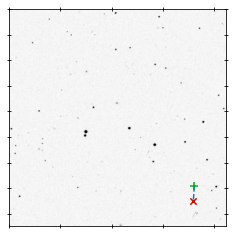

2023-11-27 07:22:07 - >>> DSS finder chart written to finder_chart_2023RN3_F65_20231118_dss.png.
2023-11-27 07:22:07 - Done.


In [13]:
#generate_fscoords_finder_chart_gaia('358P','G37','2023-10-16 00:00:00.000','/volumes/Fantom12a/BackupData/Data2023/ut20231016_ldt/',5)
#generate_fscoords_finder_chart_gaia('P/2018 P3','G37','2023-10-13 00:00:00.000','/volumes/Fantom12a/BackupData/Data2023/ut20231013_ldt/',5)
#generate_fscoords_finder_chart_gaia('426P','G37','2023-10-14 00:00:00.000','/volumes/Fantom12a/BackupData/Data2023/ut20231014_ldt/',5)
#generate_fscoords_finder_chart_gaia('62412','G37','2023-10-14 00:00:00.000','/volumes/Fantom12a/BackupData/Data2023/ut20231014_ldt/',5)
#generate_fscoords_finder_chart_gaia('358P','G37','2023-10-19 00:00:00.000','/volumes/Fantom12a/BackupData/Data2023/ut20231019_ldt/',5)
#generate_fscoords_finder_chart_gaia('P/2018 P3','G37','2023-10-19 00:00:00.000','/volumes/Fantom12a/BackupData/Data2023/ut20231019_ldt/',5)

#generate_fscoords_finder_chart_gaia('358P','675','2023-10-10 00:00:00.000','/volumes/Fantom12a/BackupData/Data2023/ut20231010_palomar/',5)
#generate_fscoords_finder_chart_gaia('426P','675','2023-10-10 00:00:00.000','/volumes/Fantom12a/BackupData/Data2023/ut20231010_palomar/',5)
#generate_fscoords_finder_chart_gaia('427P','675','2023-10-10 00:00:00.000','/volumes/Fantom12a/BackupData/Data2023/ut20231010_palomar/',5)
#generate_fscoords_finder_chart_gaia('433P','675','2023-10-10 00:00:00.000','/volumes/Fantom12a/BackupData/Data2023/ut20231010_palomar/',5)
#generate_fscoords_finder_chart_gaia('455P','675','2023-10-10 00:00:00.000','/volumes/Fantom12a/BackupData/Data2023/ut20231010_palomar/',5)
#generate_fscoords_finder_chart_gaia('456P','675','2023-10-10 00:00:00.000','/volumes/Fantom12a/BackupData/Data2023/ut20231010_palomar/',5)
#generate_fscoords_finder_chart_gaia('62412','675','2023-10-10 00:00:00.000','/volumes/Fantom12a/BackupData/Data2023/ut20231010_palomar/',5)

#generate_fscoords_finder_chart_gaia('358P','G37','2023-09-22 00:00:00.000','/volumes/Fantom12a/BackupData/Data2023/ut20230922_ldt/',5)
#generate_fscoords_finder_chart_gaia('313P','568','2015-12-09 00:00:00.000','/volumes/Fantom12a/BackupData/TargetedObjects/MBCs/313P/keck_lris/',5)
#generate_fscoords_finder_chart_gaia_ephems('2023 RN3','Z31','2023-11-16 20:00:00.000','/users/hhsieh/dropbox/hhsieh_db/astro_db/00_2023RM3/',5)

generate_fscoords_finder_chart_gaia_ephems('2023 RN3','F65','2023-11-18 00:00:00.000','/volumes/Fantom12a/BackupData/Data2023/ut20231118_ftn/',5)

#generate_fscoords_finder_chart_gaia_coords(ra_coord,dec_coord,'/users/hhsieh/dropbox/hhsieh_db/astro_db/00_2023RM3/')
